In [1]:
import numpy as np
import gurobipy as gp
from algorithms import *

Variables to be used to generate nodes and cluster

In [2]:
np.random.seed(42)

# Number of nodes
n = 200
# Number of clusters
p = 5

capacity_mean = 10
capacity_stddev = 2
weight_mean = 1
weight_stddev = 0.1
lambda_param = 0.5

Generate random nodes, capacities, and weights

In [3]:
np.random.seed(42)

# Generate 2D nodes and random capacities for clusters
nodes, capacities = generate_instances(n, p, capacity_mean, capacity_stddev)
# Generate random weight for each node
weights = generate_weights(n, weight_mean, weight_stddev)

Run CCP - Gurobi clustering algorithm

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-06
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1201 rows, 1200 columns and 3005 nonzeros
Model fingerprint: 0x895df3f4
Variable types: 0 continuous, 1200 integer (1200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-04, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 32.6241161
Presolve removed 1 rows and 195 columns
Presolve time: 0.01s
Presolved: 1200 rows, 1005 columns, 3000 nonzeros
Variable types: 0 continuous, 1005 integer (1005 binary)
Found heuristic solution: objective -25.0843620

Root relaxation: objective -3.227499e+01, 243 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu

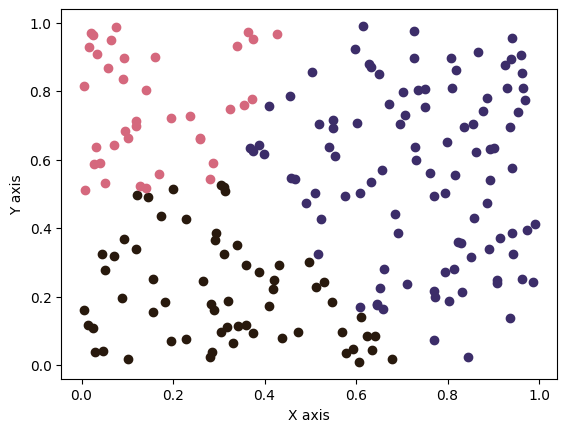

In [4]:
clusters, time1, obj_val = solve_model(nodes, capacities, weights, lambda_param,'ccp')

plot_clusters(clusters,nodes)


Run Greedy (Heuristic ) clustering algorithm

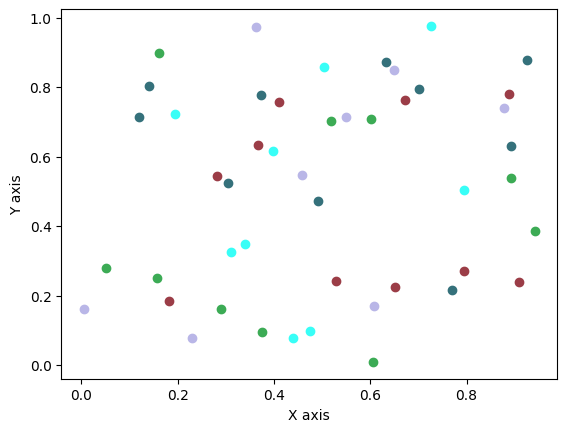

In [5]:
greedy_clusters, time2 = greedy_clustering(nodes, capacities, weights)

plot_clusters(greedy_clusters,nodes)



Calculate In Sample Stability

In [6]:
insample_stability_score = insample_stability(clusters,nodes, capacities, weights, lambda_param, num_runs=100)
print("Insample Stability:",insample_stability_score)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1201 rows, 1200 columns and 3005 nonzeros
Model fingerprint: 0x895df3f4
Variable types: 0 continuous, 1200 integer (1200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-04, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 32.6241161
Presolve removed 1 rows and 195 columns
Presolve time: 0.01s
Presolved: 1200 rows, 1005 columns, 3000 nonzeros
Variable types: 0 continuous, 1005 integer (1005 binary)
Found heuristic solution: objective -25.0843620

Root relaxation: objective -3.227499e+01, 243 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     -32.2749905  -32.274

Calculate Out Sample Stability

In [7]:
outsample_stability_score = outsample_stability(n, p, weight_mean, weight_stddev, capacity_mean, capacity_stddev, lambda_param, num_runs=10)

print("Outsample Stability:",outsample_stability_score)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 841 rows, 840 columns and 2105 nonzeros
Model fingerprint: 0xcc7b4286
Variable types: 0 continuous, 840 integer (840 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 21.4065494
Presolve removed 1 rows and 135 columns
Presolve time: 0.01s
Presolved: 840 rows, 705 columns, 2100 nonzeros
Variable types: 0 continuous, 705 integer (705 binary)
Found heuristic solution: objective -11.1317007

Root relaxation: objective -1.893189e+01, 326 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     -18.9318895  -18.93189  0.00

Calculate VSS

In [8]:
num_simulations = 100
np.random.seed(42)
VSS = calculate_VSS(n, p, capacity_mean, capacity_stddev, weight_mean, weight_stddev, lambda_param, num_simulations)
print(f"The Value of Stochastic Solution (VSS) is {VSS:.2f}")

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1201 rows, 1200 columns and 3005 nonzeros
Model fingerprint: 0x895df3f4
Variable types: 0 continuous, 1200 integer (1200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-04, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 32.6241161
Presolve removed 1 rows and 195 columns
Presolve time: 0.01s
Presolved: 1200 rows, 1005 columns, 3000 nonzeros
Variable types: 0 continuous, 1005 integer (1005 binary)
Found heuristic solution: objective -25.0843620

Root relaxation: objective -3.227499e+01, 243 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     -32.2749905  -32.274